In [1]:
import os

# JAX runs the fastest for squark in general based on our experience
os.environ['KERAS_BACKEND'] = 'jax'


import keras
from keras import ops
from matplotlib import pyplot as plt
import numpy as np

from squark.config import QuantizerConfig, QuantizerConfigScope
from squark.layers import QEinsumDense, QEinsumDenseBatchnorm
from squark.layers import QDense
from squark.layers import QSoftmax
from squark.utils.sugar import FreeEBOPs, PBar

In [2]:
import pickle as pkl
from pathlib import Path
import zstd
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def get_data(data_path: Path, seed=42):

    if not os.path.exists(data_path):
        print('Downloading data...')
        data = fetch_openml('hls4ml_lhc_jets_hlf')
        buf = pkl.dumps(data)
        with open(data_path, 'wb') as f:
            f.write(zstd.compress(buf))
    else:
        os.makedirs(data_path.parent, exist_ok=True)
        with open(data_path, 'rb') as f:
            data = pkl.loads(zstd.decompress(f.read()))

    X, y = data['data'], data['target']
    codecs = {'g': 0, 'q': 1, 't': 4, 'w': 2, 'z': 3}
    y = np.array([codecs[i] for i in y])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    X_train_val, X_test, y_train_val, y_test = X_train_val.astype(np.float32), X_test.astype(np.float32), y_train_val, y_test

    scaler = StandardScaler()
    X_train_val = scaler.fit_transform(X_train_val)
    X_test = scaler.transform(X_test)
    
    X_train_val = X_train_val.astype(np.float32)
    y_train_val = y_train_val.astype(np.float32)

    return X_train_val, X_test, y_train_val, y_test


X_train,X_test,y_train,y_test = get_data(Path('/tmp/inp_data.zst'))

In [3]:
from squark.quantizer.internal.float_point_ops import float_quantize

In [4]:
from squark.utils.sugar import Dataset

y_train = keras.utils.to_categorical(y_train, num_classes=5)
y_test = keras.utils.to_categorical(y_test, num_classes=5)

dataset_train = Dataset(X_train, y_train, batch_size=33200, device='gpu:0')
dataset_test = Dataset(X_test, y_test, batch_size=33200, device='gpu:0')

In [5]:
np.random.seed(42)
import random
random.seed(42)

In [6]:
# scope0 = QuantizerConfigScope(place=('weight', 'bias', 'table'), k0=1, b0=3, i0=0, default_q_type='kbi', overflow_mode='sat_sym')
from squark.regularizers import MonoL1

# Skipping these should also work.
scope0 = QuantizerConfigScope(place='all', k0=1, b0=3, i0=0, default_q_type='kbi', overflow_mode='sat_sym')
scope1 = QuantizerConfigScope(place='datalane', k0=0, default_q_type='kif', overflow_mode='wrap', f0=3, i0=3)

exp_table_conf = QuantizerConfig('kif', 'table', k0=0, i0=1, f0=8, overflow_mode='sat_sym')
inv_table_conf = QuantizerConfig('kif', 'table', k0=1, i0=4, f0=4, overflow_mode='sat_sym')
# Layer scope will over formal one. When using scope0, scope1, 'datalane' config will be overriden with config in scope1

In [7]:
use_softmax = False
# QSoftmax is bit-accurate (hopefully), but it can give exactly zero now: xentropy will diverge and thus USE WITH CAUTION

In [8]:
def build_model(use_softmax=False, beta0=1e-5):
    with scope0, scope1:
        iq_conf = QuantizerConfig(place='datalane', k0=1)
        oq_conf = QuantizerConfig(place='datalane', k0=1, fr=MonoL1(1e-3))
        layers = [
            QDense(64, beta0=beta0, iq_conf=iq_conf, activation='relu', name='dense_0'),
            QDense(32, beta0=beta0, activation='relu', name='dense_1'),
            QDense(32, beta0=beta0, activation='relu', name='dense_2'),
            QDense(5, beta0=beta0, enable_oq=not use_softmax, name='dense_3', oq_conf=oq_conf),
            # QEinsumDense('...c,oc->...o', 64, bias_axes='o', beta0=beta0, iq_conf=iq_conf, activation='relu', bame='dense_0'),
            # QEinsumDense('...c,oc->...o', 32, bias_axes='o', beta0=beta0, activation='relu', name='dense_1'),
            # QEinsumDense('...c,oc->...o', 32, bias_axes='o', beta0=beta0, activation='relu', name='dense_2'),
            # QEinsumDense('...c,oc->...o', 5, bias_axes='o', beta0=beta0, enable_oq=not use_softmax, name='dense_3'),
        ]
        if use_softmax:
            layers.append(QSoftmax(exp_oq_conf=exp_table_conf, inv_oq_conf=inv_table_conf))
    
    model = keras.models.Sequential(layers)
    return model

In [9]:
model = build_model(use_softmax=use_softmax, beta0=0.5e-5)
if not use_softmax:
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
else:
    loss = keras.losses.CategoricalHinge()
opt = keras.optimizers.Adam(learning_rate=5e-3)

model.compile(opt, loss, metrics=['accuracy'], jit_compile=True, steps_per_execution=4)

In [10]:
pbar = PBar('loss: {loss:.3f}/{val_loss:.3f} - acc: {accuracy:.3f}/{val_accuracy:.3f}')
ebops = FreeEBOPs()
nan_terminate = keras.callbacks.TerminateOnNaN()

In [11]:
history = model.fit(dataset_train, epochs=3000, batch_size=33200, validation_data=dataset_test, verbose=0, callbacks=[ebops, pbar, nan_terminate])

loss: 0.637/0.622 - acc: 0.759/0.756 - EBOPs: 4,083: 100%|██████████| 3000/3000 [03:10<00:00, 15.71epoch/s] 


In [12]:
model.evaluate(dataset_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7559 - loss: 0.6216


[0.6217148900032043, 0.7559036016464233]

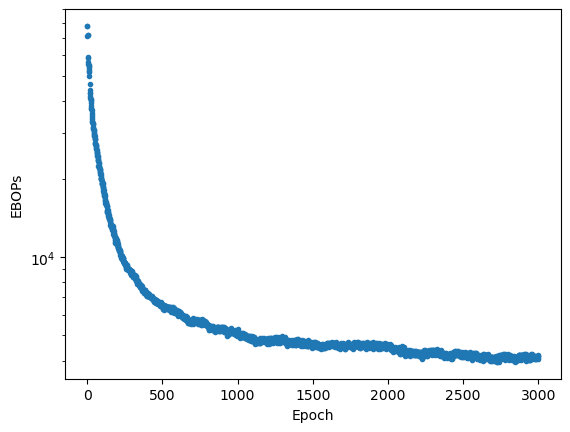

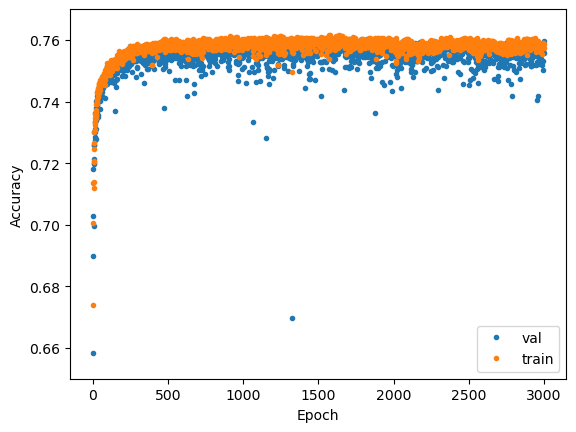

In [13]:
plt.plot(history.history['ebops'], '.')
plt.ylabel('EBOPs')
plt.yscale('log')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['val_accuracy'], '.', label='val')
plt.plot(history.history['accuracy'], '.', label='train')
plt.legend()
plt.ylabel('Accuracy')
plt.ylim(0.65, 0.77)
plt.xlabel('Epoch')
plt.show()

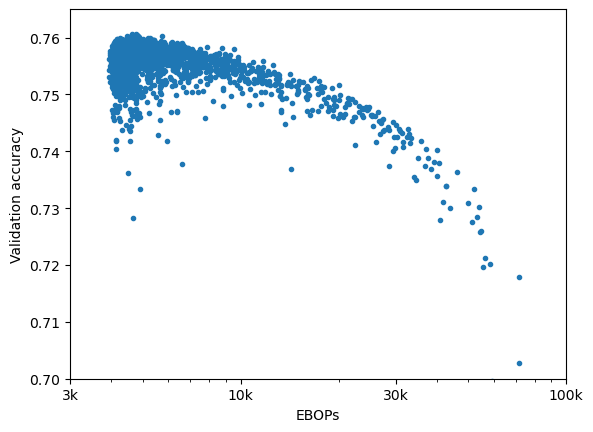

In [14]:
plt.plot(history.history['ebops'], history.history['val_accuracy'], '.')
plt.xscale('log')
plt.xlabel('EBOPs')
plt.ylabel('Validation accuracy')
plt.ylim(0.7, 0.765)
plt.xticks([3000, 10000, 30000, 100000], ['3k', '10k', '30k', '100k'])
plt.show()